# Gaussian mixture model

In [1]:
# Load generated data from file:
import pickle

from evaluation_icml2022 import *

experiments = {}
num_chains = 10
configs = [
    (L, alpha, K) for L in [25] for alpha in [1.0, 0.5] for K in [0, 1, 2]
]
for L, alpha, K in configs:
    key = toconfigstr(None, alpha, K)
    experiments[key] = []
    for i in range(num_chains):
        with open(f"lookahead_samples/gmm_{i}__count1000_eps0.05_L{L}_alpha{alpha}_K{K}.pickle", "rb") as f:
            experiments[key].append(pickle.load(f))

In [2]:
adjusted_experiments = adjust_for_iteration_time(experiments)

effort=defaultdict(<class 'list'>, {('npdhmc', ''): [25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000], ('npladhmc', 'K=1'): [30425, 31525, 30450, 29600, 31300, 31300, 31600, 31075, 30675, 31550], ('npladhmc', 'K=2'): [33300, 36025, 33925, 33300, 34475, 33675, 34400, 35700, 35075, 35000], ('npdhmc-persistent', 'α=0.5'): [25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000], ('npladhmc-persistent', 'α=0.5, K=1'): [30175, 31775, 30925, 30800, 30000, 30675, 29725, 30025, 30550, 31150], ('npladhmc-persistent', 'α=0.5, K=2'): [33950, 35175, 33475, 34575, 34625, 34250, 34825, 33900, 35050, 34750]})
reduction_factor={('npdhmc', ''): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], ('npladhmc', 'K=1'): [1.217, 1.261, 1.218, 1.184, 1.252, 1.252, 1.264, 1.243, 1.227, 1.262], ('npladhmc', 'K=2'): [1.332, 1.441, 1.357, 1.332, 1.379, 1.347, 1.376, 1.428, 1.403, 1.4], ('npdhmc-persistent', 'α=0.5'): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], ('npladhm

In [3]:
chains = {}
for config, runs in adjusted_experiments.items():
    print(f"{config}")
    thinned_runs = thin_runs(runs)
    chains.update(collect_chains(thinned_runs, config=config))
    print_running_time(runs, thinned_runs)


npdhmc: 804.15s    0.0804s per sample (after thinning)
K=1
npladhmc: 803.50s    0.0995s per sample (after thinning)
K=2
npladhmc: 804.91s    0.1111s per sample (after thinning)
α=0.5
npdhmc-persistent: 814.48s    0.0814s per sample (after thinning)
α=0.5, K=1
npladhmc-persistent: 809.70s    0.0991s per sample (after thinning)
α=0.5, K=2
npladhmc-persistent: 806.52s    0.1112s per sample (after thinning)


In [4]:
import torch

print("Acceptance ratios (lookahead statistics in parentheses):")
for config, runs in experiments.items():
    for method in runs[0].keys():
        stats = sum(torch.tensor(run[method]["stats"]) for run in runs)
        ratios = (stats.true_divide(torch.sum(stats))).tolist()
        accept_ratio = 1.0 - ratios[0]
        ratios_str = ", ".join(f"{r*100:.1f}%" for r in ratios[1:])
        print(f"{legend_str((method, config))}: {accept_ratio * 100:.1f}% ({ratios_str})")

Acceptance ratios (lookahead statistics in parentheses):
NP-DHMC: 75.6% (75.6%)
NP-Lookahead-DHMC (K=1): 84.8% (76.2%, 8.6%)
NP-Lookahead-DHMC (K=2): 88.6% (77.0%, 8.0%, 3.6%)
NP-DHMC pers. (α=0.5): 77.9% (77.9%)
NP-Lookahead-DHMC pers. (α=0.5, K=1): 85.6% (77.7%, 7.9%)
NP-Lookahead-DHMC pers. (α=0.5, K=2): 88.4% (77.5%, 7.2%, 3.7%)


In [5]:
import torch
import math
import example_gmm as gmm

def gmm_lppd(samples):
    M = len(samples)
    N = len(gmm.test_data)
    #compute the probability density for each data point and sapmle (size M x N):
    logps = torch.stack([gmm.loglikelihoods(torch.tensor(sample), gmm.test_data) for sample in samples])
    # average over all samples:
    logp_avg = torch.logsumexp(logps, dim=0) - math.log(float(M))
    # sum over all test data points:
    lppd = torch.sum(logp_avg)
    return lppd

def gmm_lppd_stats(chains):
    lppds = torch.tensor([gmm_lppd(chain) for chain in chains])
    std, mean = torch.std_mean(lppds)
    return mean.item(), std.item()

def print_gmm_lppd_stats(chains):
    mean, std = gmm_lppd_stats(chains)
    return f"{mean:.2f} +- {std:.2f} (standard deviation)"

print("Log posterior predictive densities:")
print(f"True LPPD:  {print_gmm_lppd_stats([[gmm.data_means.tolist()]])}")
for method in chains.keys():
    print(f"{legend_str(method)}:  {print_gmm_lppd_stats(chains[method])}")

Log posterior predictive densities:
True LPPD:  -674.81 +- nan (standard deviation)
NP-DHMC:  -675.59 +- 0.37 (standard deviation)
NP-Lookahead-DHMC (K=1):  -675.57 +- 0.32 (standard deviation)
NP-Lookahead-DHMC (K=2):  -675.44 +- 0.36 (standard deviation)
NP-DHMC pers. (α=0.5):  -675.43 +- 0.20 (standard deviation)
NP-Lookahead-DHMC pers. (α=0.5, K=1):  -675.37 +- 0.18 (standard deviation)
NP-Lookahead-DHMC pers. (α=0.5, K=2):  -675.27 +- 0.44 (standard deviation)


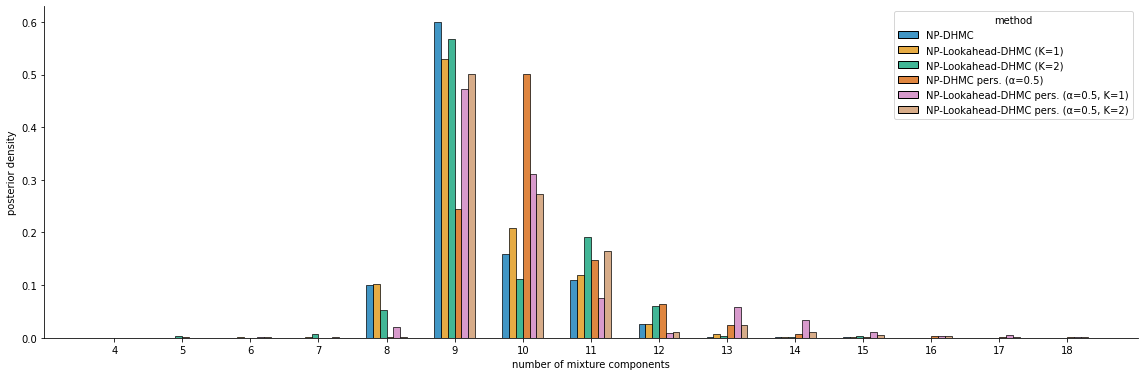

In [6]:
# Plot the number of mixture components
import pandas
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def toListOfKs(xss):
    return [len(x) for xs in xss for x in xs]

data = []
for method in chains.keys():
    data += [(legend_str(method), k) for k in toListOfKs(chains[method])]

x_label = "number of mixture components"
dataframe = pandas.DataFrame(data, columns=["method", x_label])
plot = sns.displot(
    data=dataframe,
    x=x_label,
    hue="method",
    stat="density",
    common_norm=False,
    discrete=True,
    binrange=(4,18),
    multiple="dodge",
    shrink=0.6,
    aspect=3.0,
    facet_kws={"legend_out": False},
    height=16/3,
)
plot.set_ylabels(label="posterior density")
plt.xticks([i for i in range(4, 19)])
plot.savefig("icml2022-gmm-histogram.pdf", bbox_inches="tight")

In [7]:
# graph LPPD progression:
from tqdm import tqdm
lppd_data = []
num_samples = max(len(c) for cs in chains.values() for c in cs)
resolution = 20
# start = 1
start = 2
for i in tqdm(range(start, resolution + 1)):
    for method in chains.keys():
        num_chains = len(chains[method])
        min_chain_length = min(len(c) for c in chains[method])
        n = i * num_samples // resolution
        if n <= min_chain_length:
            truncated_lppds = [gmm_lppd(chain[:n]).item() for chain in chains[method]]
        else:
            truncated_lppds = [None for _ in chains[method]]
        lppd_data += [(legend_str(method), n, lppd) for lppd in truncated_lppds]
    lppd_data.append(("ground truth", n, gmm_lppd([gmm.data_means.tolist()]).item()))

100%|██████████| 19/19 [01:54<00:00,  6.05s/it]


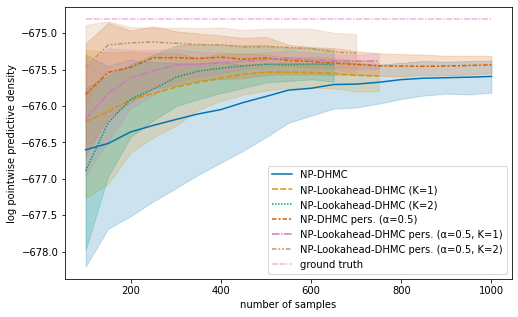

In [8]:
cut_off_lppd_data = []
df = pandas.DataFrame(lppd_data, columns=["method", "number of samples", "log pointwise predictive density"])
plt.figure(figsize=(8,5))
plot = sns.lineplot(
    data=df,
    x="number of samples",
    y="log pointwise predictive density",
    hue="method",
    style="method",
)
plt.legend(loc="lower right")
plt.show()
plot.get_figure().savefig("icml2022-gmm-lppd-plot.pdf", bbox_inches="tight")